In [62]:
from keras.models import load_model
model_path = '../image_models/Covid_2class_9947_softmax.h5'
seg_model_path = '../image_models/seg_model.h5'
feature_model_path = '../image_models/DenseNet201.h5'

def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

model = load_model(model_path)
feature_model = load_model(feature_model_path)
seg_model = load_model(seg_model_path ,custom_objects={'dice_coef_loss': dice_coef_loss,'dice_coef':dice_coef})

In [71]:
# import module


from tensorflow import keras
import tensorflow as tf
import matplotlib.cm as cm
import numpy as np 
import matplotlib.pyplot as plt
import os
from PIL import Image

def image_preprocessing(cropped_image, img_size):
    
    img = tf.keras.preprocessing.image.array_to_img(cropped_image)
    img = img.resize(img_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

#  히트맵 생성
def make_gradcam_heatmap(cropped_image , classifier_model, last_conv_layer_model,img_size):

    img_array = image_preprocessing(cropped_image,img_size)


    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        # print(preds)
        top_pred_index = tf.argmax(preds[0])
        # print(top_pred_index)
        top_class_channel = preds[:, top_pred_index]
        # print(top_class_channel)
        

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    return heatmap

# CAM이미지 + 원본
def show_CAM(cropped_image, heatmap, boundary, threshold=180):
    
    img = tf.keras.preprocessing.image.img_to_array(cropped_image)
    
    # Get boundary of cropped image and calculate original location
    t,b,l,r = boundary    

    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    
#  thresholding
#  주요 특징만 추출
    heatmap[np.where(heatmap < 120)] = 0

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("Reds")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    
    # 바탕이 밝아지는 것 막기 위해 thresholding...
    idx = np.where(jet_heatmap.mean(axis=2) > threshold)
#     jet_heatmap[idx] = img[idx]
    jet_heatmap[idx] = [255,255,255]

    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    
    return jet_heatmap

# 여러개의 heatmap 이미지를 얻는다.
def make_multi_heatmaps(cropped_image, original, original_512, heatmap, boundary, iterator=10):
    # CXR에서 어디를 어떤 근거로 분류했는지를 나타내는 heatmap을
    # 특징 강도를 기준으로 나누어 여러 개의 이미지로 만들어 반환한다.
    # 100 ~ 200 을 iterator를 기준으로 구간을 나눔.
    cam_list = []
    interval = 150 // iterator
    for threshold in range(50, 201, interval):
        cam_image = show_CAM(cropped_image , heatmap, boundary, threshold)
        original_size_heatmap = get_original_size_heatmap(cam_image, original, original_512, boundary)
        # 투명한 배경이미지의 heatmap을 저장
        get_transparent_img(original_size_heatmap, f"png_heatmaps/pngCXR_{threshold}.png")
        cam_list.append(original_size_heatmap)

    return cam_list

# 예측함수
# opencv의 resize에서 오류가 발생하여 keras.preprocessing.image의 함수들을 사용하였다.
def predict_CXR(cropped_image , model, feature_model,img_size):

    img = image_preprocessing(cropped_image,img_size)
    
    feature_vector = feature_model.predict(img)

    prediction = model.predict(feature_vector)[0]
    index = prediction.argmax()
    label_name = ['negative','positive']

    #labels에 저장 
    label = label_name[index] 
    
    # 예측 결과 / 0 ~ 1 퍼센트
    return label, prediction



def get_transparent_img(original_size_heatmap, image_name):

    img = original_size_heatmap.convert("RGBA")
    datas = img.getdata()

    newData = []
    cutOff = 255
 
    for item in datas:
        if item[0] >= cutOff and item[1] >= cutOff and item[2] >= cutOff:
            newData.append((255, 255, 255, 0))
            # RGB의 각 요소가 모두 cutOff 이상이면 transparent하게 바꿔줍니다.
        else:
            newData.append(item)
            # 나머지 요소는 변경하지 않습니다.
    
    img.putdata(newData)
    img.save(image_name, "PNG") # PNG 포맷으로 저장합니다.

In [72]:
def get_seg_img(model_seg, original_512):
    
    # pre-processing for segmentation
    test_im = keras.preprocessing.image.img_to_array(original_512)[:,:,0]
    # expand_dims
    test_X = np.array(test_im).reshape(1,512,512,1) 
    test = (test_X-127.0)/127.0

    # get segmented image
    pred_im = model_seg.predict(test)
    pred_im = (pred_im>0.1)
    return pred_im

# 최 외곽 사각형의 좌표를 구한다. 0~511/ 0~511
def get_boundingbox(pred_label):
    # Set boundaries only when more than 5 pixels are found to ignore very fine errors.
    cnt = 0
    for i in range(len(pred_label)):
        if True in pred_label[i]:
            cnt += 1
        if cnt >= 5:
            top = i
            break
    cnt = 0
    for i in range(len(pred_label)-1, 0, -1):
        if True in pred_label[i]:
            cnt += 1
        if cnt >= 5:
            bottom = i
            break
    cnt = 0
    for i in range(len(pred_label)):
        if True in pred_label[:, i]:
            cnt += 1
        if cnt >= 5:
            left = i
            break
    cnt = 0       
    for i in range(len(pred_label)-1, 0, -1):
        if True in pred_label[:,i]:
            cnt += 1
        if cnt >= 5:
            right = i
            break
    # To avid cropping too many pixels, make the bounding box loosely.
    return top//2, 512-(512-bottom)//2, left//2, 512-(512-right)//2



# Detect an CXR's lung location and crop it.
def get_cropped_image(original_512, model_seg):
    seg_img = get_seg_img(model_seg, original_512)
    t, b, l, r = get_boundingbox(seg_img[0])
    original = tf.keras.preprocessing.image.img_to_array(original_512)
    cropped_original = original[t:b+1, l:r+1]
    
    return cropped_original, (t,b,l,r)

def get_original_size_heatmap(cam_image, original, original_512, boundary):
    t,b,l,r = boundary
    # original_512로 512 heatmap 만들고 original로 크기 얻어서 heatmap을 그 크기로 만들기.
    original = tf.keras.preprocessing.image.img_to_array(original)
    cam_image = tf.keras.preprocessing.image.img_to_array(cam_image)
    original_512 = tf.keras.preprocessing.image.img_to_array(original_512)
    # 배경을 흰색으로 만들기
    original_512[:,:] = [255,255,255]

    # change the cropped location to heatmap image.
    original_512[t:b+1, l:r+1] = cam_image

    original_size_heatmap = tf.keras.preprocessing.image.array_to_img(original_512)
    original_size_heatmap = original_size_heatmap.resize((original.shape[1], original.shape[0]))
    
    return original_size_heatmap

In [73]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
import tensorflow_hub as hub
import numpy as np

def prediction_and_heatmap(image_path, model, seg_model,feature_model):
    # image path를 받아 segmentation하여 폐부분을 포커싱한 cropped image를 얻고
    # 이 부분을 통해 실제로 예측을 수행한다.
    # 원본사진으로 모델을 통과시켜 히트맵을 얻는다.
    
    img_size = (224,224)
    original = tf.keras.preprocessing.image.load_img(image_path)
    original_512 = tf.keras.preprocessing.image.load_img(image_path, target_size=(512,512))
    
    cropped_image, boundary = get_cropped_image(original_512, seg_model)
    
    prediction, percent = predict_CXR(cropped_image , model, feature_model,img_size)
    heatmap = make_gradcam_heatmap(cropped_image, model, feature_model, img_size)
    cam_image = show_CAM(cropped_image , heatmap, boundary, 200)
    
    original_size_heatmap = get_original_size_heatmap(cam_image, original, original_512, boundary)
    
    # cam_image를 threshold별로 다른 이미지를 얻는다.
    # cam_list는 안씀
    cam_list = make_multi_heatmaps(cropped_image, original,original_512, heatmap, boundary, 10)
    
    return prediction, percent,original_size_heatmap, original

In [77]:
image_path = '../../CXR_data/train/positive/38.jpeg'
# '../../CXR_data/train/negative/0b00ec19-0e23-48eb-8936-c03379bf65c2.jpg'
# '../../CXR_data/train/positive/38.jpeg'

# 'covid.jpg'

In [78]:
prediction, percent,original_size_heatmap ,original = prediction_and_heatmap(image_path, model, seg_model, feature_model)

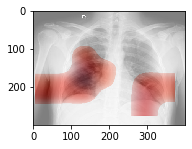

In [79]:
import matplotlib.pyplot as plt
original_size_heatmap = tf.keras.preprocessing.image.img_to_array(original_size_heatmap)
original = tf.keras.preprocessing.image.img_to_array(original)
test = original_size_heatmap *0.5 + original * 0.5
test = test.astype(int)
plt.subplot(1,2,1)
plt.imshow(test)